Preliminary Calculations

In [12]:
import os
import matplotlib.pyplot as plt
from math import log
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text

dir = '/Users/k/Docs/School/Tuebingen/Thesis/iscl-thesis/current_corpora/'
files = [os.path.join(dir, file) for file in os.listdir(dir) if file.endswith('.txt')]

Type-Token Ratio

In [13]:
def calculate_ttr(file):
    
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    tokens = text.split()
    total_tokens = len(tokens)
    types = set(tokens)
    total_types = len(types)
    ttr = (total_types / total_tokens) * 100
    return ttr

ttr_values = {}
for file in files:
    lang = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    ttr_values[lang] = calculate_ttr(file)

Moving Average Type-Token Ratio

In [14]:
def calculate_mattr(file, window_size):
    
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    tokens = text.split()
    total_tokens = len(tokens)
    
    ttr_values = []
    for i in range(total_tokens - window_size + 1):
        window = tokens[i:i + window_size]
        types = set(window)
        total_types = len(types)
        ttr = total_types / window_size
        ttr_values.append(ttr)

    mattr = sum(ttr_values) / len(ttr_values)
    return mattr

mattr_values = {}
window_size = 100  
for file in files:
    lang = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    mattr_values[lang] = calculate_mattr(file, window_size)

Character Entropy

In [15]:
def log2(number):
    return log(number) / log(2)

def calculate_char_entropy(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    char_freq = {}
    for char in text:
        if char in char_freq:
            char_freq[char] += 1
        else:
            char_freq[char] = 1
            
    length_sum = 0.0
    for char in char_freq:
        p = float(char_freq[char]) / len(text)
        length_sum += p * log2(p)
        
    return -length_sum

char_entropies = {}
for file in files:
    lang = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    char_entropies[lang] = calculate_char_entropy(file)

Word Entropy

In [16]:
def log2(number):
    return log(number) / log(2)

def calculate_word_entropy(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    word_freq = {}
    total_words = 0
    for word in text.split():
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1
        total_words += 1
            
    length_sum = 0.0
    for word in word_freq:
        p = float(word_freq[word]) / total_words
        length_sum += p * log2(p)
        
    return -length_sum

word_entropies = {}
for file in files:
    lang = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    word_entropies[lang] = calculate_word_entropy(file)

Dataframe

In [17]:
calculations = {
   'TTR': ttr_values,
   'MATTR': mattr_values,
   'Char Entr': char_entropies,
   'Word Entr': word_entropies
}

for label, dic in calculations.items():
    calculations[label] = pd.Series(dic)

df = pd.DataFrame(calculations)

df2 = df.copy()
df2['corpus'] = df2.index
df2 = df2[['corpus', 'TTR', 'MATTR', 'Char Entr', 'Word Entr']]
df2.to_csv('prelim.csv', sep='\t', index=False)

Principle Component Analysis

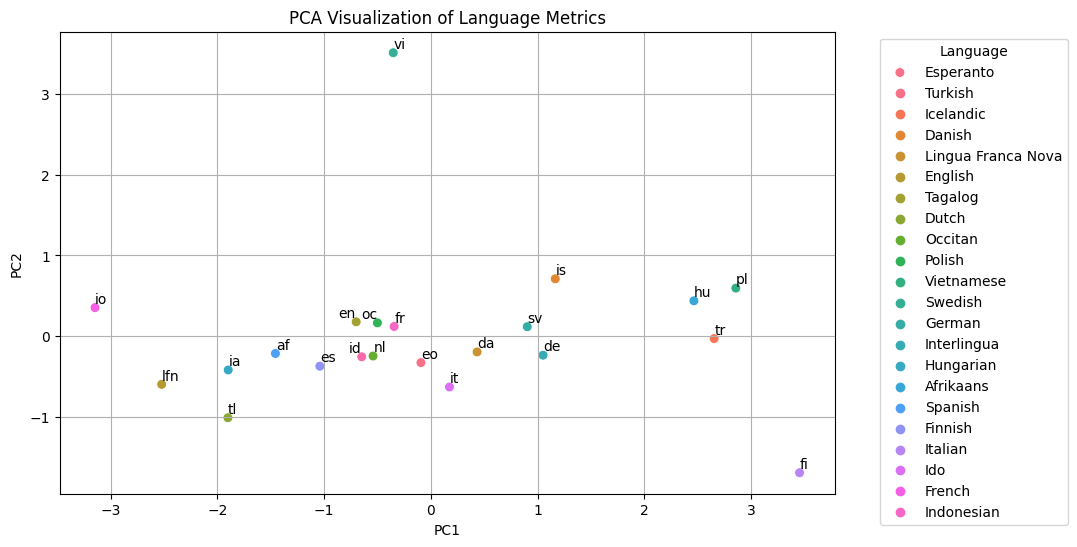

In [18]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df.index = df.index

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue=pca_df.index, s=50)

texts = []
for i, language in enumerate(pca_df.index):
    texts.append(plt.annotate(language, (pca_df['PC1'][i], pca_df['PC2'][i])))
    
adjust_text(texts)

lang_labels = {
    'sv': 'Swedish', 
    'id': 'Indonesian', 
    'eo': 'Esperanto',
    'is': 'Icelandic',
    'pl': 'Polish',
    'da': 'Danish',
    'tl': 'Tagalog',
    'ia': 'Interlingua',
    'fi': 'Finnish',
    'vi': 'Vietnamese',
    'hu': 'Hungarian',
    'nl': 'Dutch',
    'lfn': 'Lingua Franca Nova',
    'es': 'Spanish',
    'io': 'Ido',
    'af': 'Afrikaans',
    'fr': 'French',
    'it': 'Italian',
    'tr': 'Turkish',
    'de': 'German',
    'oc': 'Occitan',
    'en': 'English'
    }
legend_labels = [lang_labels[abb] for abb in pca_df.index]
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Visualization of Language Metrics')
plt.grid(True)
plt.legend(title='Language', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
plt.show()

In [19]:
pca.explained_variance_ratio_

array([0.73985807, 0.21430416])

Perplexity Analysis from RNNs

In [3]:
perplexity_df = pd.read_csv('lex_entropy_hist_df.csv')
perplexity_df

,Unnamed: 0,corpus,epoch,loss,acc,val_loss,val_acc
0,0,sv,28,1.628169,0.496183,1.789138,0.455363
1,1,id,15,1.852628,0.427313,1.983487,0.390511
2,2,eo,26,1.645993,0.465386,1.807475,0.425102
3,3,is,26,1.614282,0.505864,1.758496,0.471116
4,4,pl,40,1.513581,0.523202,1.661213,0.488448
5,5,da,20,1.679666,0.484289,1.812895,0.451150
6,6,tl,19,1.741481,0.462846,1.876834,0.427406
7,7,ia,21,1.666016,0.470437,1.843534,0.425380
8,8,fi,29,1.491198,0.520128,1.574989,0.499064
9,9,vi,22,2.205411,0.357184,2.432599,0.303962


Char Embeddings: Char2Vec (from https://github.com/sonlamho/Char2Vec/tree/master)

In [ ]:
from Char2Vec.char2vec.utils import *
from Char2Vec.char2vec.embed import *

In [ ]:
corpus_path = '/Users/k/Docs/School/Tuebingen/Thesis/iscl-thesis/current_corpora/en_wiki_extractor.txt'
alpha = 'abcdefghijklmnopqrstuvwxyz '

In [ ]:
m = Char2Vec(corpus_path, config=CONFIG, alphabet=alpha, unk='~')
m.train()

In [ ]:
# Visualize Char Embeddings
def scatter2d_with_annotation(arr, text, xcol=0, ycol=1, fontsize=7, show=False, **kwargs):
    
    assert len(arr)==len(text)
    fig, ax = plt.subplots(**kwargs)
    xarr = arr[:, xcol]
    yarr = arr[:, ycol]
    plt_texts = []
    
    for i in range(len(text)):
        plt.scatter(xarr[i], yarr[i])
        plt_texts.append(plt.text(xarr[i], yarr[i], text[i], fontsize=fontsize))
        
    if show:
        plt.show()
    return fig, ax

# Char embedding matrix U
U = m.U_

p = PCA()

In [ ]:
U2 = p.fit_transform(U)
texts = m._tokenizer.alphabet + [m._tokenizer.unk]
fig, ax = scatter2d_with_annotation(
            U2, [s.upper() for s in texts],
            0,1,
            figsize=(8,5), fontsize=13)
plt.title('PCA of Character embeddings, Dim-0 vs Dim-1')
plt.show()

In [ ]:
U3 = TSNE(n_components=2, perplexity=5).fit_transform(U)
fig, ax = scatter2d_with_annotation(
            U3, [s.upper() for s in texts],
            0,1,
            figsize=(8,5), fontsize=13)
plt.title('T-SNE of Character embeddings, Perplexity=5')
plt.show()